In [32]:
import pefile
import os
import re


import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, jaccard_score
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import euclidean_distances

import networkx as nx

Obteniendo características de los malwares.

In [9]:
ruta_carpeta = './MALWR/MALWR/'

data = {}

for nombre_archivo in os.listdir(ruta_carpeta):
    ruta_archivo = os.path.join(ruta_carpeta, nombre_archivo)
    if os.path.isfile(ruta_archivo):
        pe = pefile.PE(ruta_archivo)

        # Información del PE Header
        print("Nombre del archivo: ", pe.FILE_HEADER)

        # Nombres de las secciones
        secciones = []
        for section in pe.sections:
            print(section.Name.decode().rstrip('\x00'))
            secciones.append(section.Name.decode().rstrip('\x00'))

        # Llamadas a funciones
        funciones = []
        for entry in pe.DIRECTORY_ENTRY_IMPORT:
            print('DLL: ', entry.dll.decode())
            for imp in entry.imports:
                print('\t', hex(imp.address), imp.name.decode() if imp.name else '')
                funciones.append({
                    'DLL': entry.dll.decode(),
                    'Función': imp.name.decode() if imp.name else '',
                    'Dirección': hex(imp.address)
                })

        # Cadenas de texto
        strings = list(re.findall(b"[A-Za-z0-9/\-:.,_$%'()[\]<> ]{3,}", pe.__data__))
        print('Cadenas de texto: ', strings)

        # Recursos
        recursos = []
        if hasattr(pe, 'DIRECTORY_ENTRY_RESOURCE'):
            for resource_type in pe.DIRECTORY_ENTRY_RESOURCE.entries:
                if resource_type.name is not None:
                    print('Tipo de recurso: ', resource_type.name)
                    recursos.append(resource_type.name.decode('utf-8', 'ignore'))
                else:
                    print('Tipo de recurso: ', pefile.RESOURCE_TYPE.get(resource_type.struct.Id))
                    recursos.append(pefile.RESOURCE_TYPE.get(resource_type.struct.Id))

        # Firmas digitales
        firmas = []
        if hasattr(pe, 'VS_VERSIONINFO'):
            if hasattr(pe, 'FileInfo'):
                for fileinfo in pe.FileInfo:
                    if hasattr(fileinfo, 'StringTable'):
                        for st in fileinfo.StringTable:
                            for entry in st.entries.items():
                                print(entry)
                                firmas.append(entry)

        # Almacenando la información en un diccionario.
        data[nombre_archivo] = {
            'Secciones': secciones,
            'Funciones': funciones,
            'Cadenas de texto': strings,
            'Recursos': recursos,
            'Firmas digitales': firmas
        }

df = pd.DataFrame.from_dict(data, orient='index')

df.insert(0, 'Nombre', df.index)

# Eliminando la primera columna
df = df.reset_index(drop=True)

df.to_csv('malwr.csv', index=False)

Nombre del archivo:  [IMAGE_FILE_HEADER]
0xEC       0x0   Machine:                       0x14C     
0xEE       0x2   NumberOfSections:              0x3       
0xF0       0x4   TimeDateStamp:                 0x4B50A3F8 [Fri Jan 15 17:20:56 2010 UTC]
0xF4       0x8   PointerToSymbolTable:          0x0       
0xF8       0xC   NumberOfSymbols:               0x0       
0xFC       0x10  SizeOfOptionalHeader:          0xE0      
0xFE       0x12  Characteristics:               0x10F     
UPX0
UPX1
.rsrc
DLL:  KERNEL32.DLL
	 0x4070bc LoadLibraryA
	 0x4070c0 ExitProcess
	 0x4070c4 GetProcAddress
	 0x4070c8 VirtualProtect
DLL:  MSVCRT.dll
	 0x4070d0 atol
DLL:  USER32.dll
	 0x4070d8 LoadStringA
DLL:  WS2_32.dll
	 0x4070e0 send
Cadenas de texto:  [b'This program cannot be run in DOS mode.', b'Rich', b'UPX0', b'UPX1', b'.rsrc', b'3.96', b'UPX', b'tpW', b'PQR', b'RSU', b'VWS.', b'oWA', b'L40', b'$XJ', b'RPX48', b"'FE", b'w0fi', b'N8/', b'3XeX', b'rDQP', b'(hT', b'uXj', b't1a', b']USh', b'<CS', b'V3P'

El anterior código se preparó con la siguiente intención: 

1. **Lectura del archivo CSV**: El código carga un archivo CSV llamado 'malwr.csv' en un DataFrame de Pandas llamado `df`.

2. **Conversión de cadenas de texto a listas y diccionarios**: El código convierte todas las columnas que contienen datos en formato de cadenas de texto en listas y diccionarios, utilizando la función `ast.literal_eval()`.

3. **Transformación de listas en vectores de características**: Se utiliza `MultiLabelBinarizer()` de scikit-learn para poder transformar las listas de datos en vectores binarios de características. Esto se hace para las columnas 'Secciones' y 'Recursos', lo que permite representar estas características de forma numérica para su posterior procesamiento.

4. **Extracción de nombres de funciones**: Se obtienen los nombres de las funciones de la lista de funciones y se conservan solo los nombres.

5. **Transformación de listas de funciones en vectores de características**: Al igual que el punto 3, se transforman las listas de nombres de funciones en vectores binarios de características.

6. **Conversión de listas de cadenas de texto a cadenas de texto**: Luegom convierten las listas de cadenas de texto en cadenas de texto únicas, para cada entrada en la columna 'Cadenas de texto'.

7. **Vectorización de cadenas de texto**: También se utiliza `TfidfVectorizer` de scikit-learn para vectorizar las cadenas de texto convertidas, lo que permite representarlas en un formato numérico adecuado para su procesamiento en algoritmos de aprendizaje automático.

8. **Eliminación de columnas no deseadas**: Por otro lado, se eliminan las columnas que contienen las firmas digitales, si están presentes en el DataFrame.

9. **Guardado del conjunto de datos procesado**: Finalmente, se guarda el DataFrame procesado en un nuevo archivo CSV llamado 'malwr.csv', listo para ser procesado y tranformado luego.


Analizando y preprocesando el dataset

In [10]:
df = pd.read_csv('malwr.csv')

# Convertiendo las cadenas de texto a listas y diccionarios
for col in ['Secciones', 'Funciones', 'Cadenas de texto', 'Recursos', 'Firmas digitales']:
    df[col] = df[col].apply(ast.literal_eval)

# Transformar las listas en vectores de características
mlb = MultiLabelBinarizer()
for col in ['Secciones', 'Recursos']:
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop(col)),
                              columns=mlb.classes_,
                              index=df.index))

# Extrayendo solo los nombres de las funciones
df['Funciones'] = df['Funciones'].apply(lambda x: [func['Función'] for func in x])

# Transformando las listas de funciones en vectores de características
mlb = MultiLabelBinarizer()
df_funciones = pd.DataFrame(mlb.fit_transform(df.pop('Funciones')),
                            columns=mlb.classes_,
                            index=df.index)
df = df.join(df_funciones.add_prefix('Función_'))

# Convertiendo las listas de cadenas de texto a cadenas de texto
df['Cadenas de texto'] = df['Cadenas de texto'].apply(lambda x: ' '.join([s.decode('utf-8', 'ignore') for s in x]))

# Vectorizando las cadenas de texto
vectorizer = TfidfVectorizer(max_features=1000)
df_cadenas = pd.DataFrame(vectorizer.fit_transform(df.pop('Cadenas de texto')).toarray(),
                          columns=vectorizer.get_feature_names_out(),
                          index=df.index)

df = df.join(df_cadenas.add_prefix('Texto_'))



if 'Firmas digitales' in df.columns:
    df = df.drop('Firmas digitales', axis=1)

# Guardando el conjunto de datos
df.to_csv('malwr_data.csv', index=False)

1. **Lectura del archivo CSV**: Primero se carga un archivo CSV llamado 'malwr.csv' en un DataFrame de Pandas llamado `df`.

2. **Conversión de cadenas de texto a listas y diccionarios**: Luego, las columnas del DataFrame que contienen datos en formato de cadenas de texto se convierten en listas y diccionarios utilizando la función `ast.literal_eval()`.

3. **Transformación de listas en vectores de características (binarización)**: Se utilizan las clases `MultiLabelBinarizer` y `fit_transform()` de scikit-learn para transformar las listas de datos en vectores binarios de características. Esto se hace para las columnas 'Secciones' y 'Recursos', lo que permite representar estas características de forma numérica para su posterior procesamiento.

4. **Extracción de nombres de funciones**: Por otro lado, se extraen los nombres de las funciones de la lista de funciones y se conservan solo los nombres.

5. **Transformación de listas de funciones en vectores de características (binarización)**: Después, se utiliza nuevamente `MultiLabelBinarizer()` para transformar las listas de nombres de funciones en vectores binarios de características.

6. **Conversión de listas de cadenas de texto a cadenas de texto única**: Luego, se convierten las listas de cadenas de texto en una única cadena de texto, uniendo así todas las cadenas con un espacio entre cada una.

7. **Vectorización de cadenas de texto (TF-IDF)**: Se utiliza `TfidfVectorizer` de scikit-learn para vectorizar las cadenas de texto convertidas, lo que permite representarlas en un formato numérico adecuado para su procesamiento en algoritmos de aprendizaje automático. Se establece un límite máximo de características a 1000.

8. **Eliminación de columnas no deseadas (Firmas digitales)**: Se elimina la columna 'Firmas digitales' si está presente en el DataFrame.

9. **Guardado del conjunto de datos procesado**: Finalmente, el se guarda DataFrame procesado en un nuevo archivo CSV llamado 'malwr_data.csv', para se utilizado en modelos posteriores.


# Aplicando algoritmos

In [4]:
df = pd.read_csv('malwr_data.csv')

# Eliminando la columna 'Nombre' ya que no es una característica
X = df.drop('Nombre', axis=1)

## Algoritmo de KMeans

A continuación se hará un modelo con las siguientes características:

1. **Inicialización de listas para almacenar errores y coeficientes de Silhouette**: Se crean dos listas vacías, `errores_kmeans` y `silhouettes_kmeans`, que se utilizarán para almacenar los errores cuadráticos medios y los coeficientes de Silhouette correspondientes a diferentes valores de K.

2. **Definición del rango de valores de K**: Luego, establece un rango de valores de K que se probarán en el algoritmo de agrupamiento KMeans. En este caso, el rango va desde 2 hasta 9 (K=2, 3, 4, ..., 9).

3. **Bucle de iteración sobre cada valor de K**: Se itera sobre cada valor de K en el rango definido.

4. **Creación y ajuste del modelo KMeans**: Para cada valor de K, se crea un modelo KMeans con el número correspondiente de clústeres y se ajusta a los datos de entrada `X`.

5. **Cálculo del error cuadrático medio**: Después se calcula el error cuadrático medio del modelo KMeans ajustado utilizando el atributo `inertia_`, que representa la suma de las distancias cuadradas de cada muestra al centro del clúster más cercano.

6. **Almacenamiento del error y etiquetado de las observaciones**: El error cuadrático medio se va agregando a la lista `errores_kmeans`. Además, se etiquetan las observaciones en el DataFrame `df` según los clústeres indicados por el modelo KMeans.

7. **Cálculo del coeficiente de Silhouette**: Luego, calcula el coeficiente de Silhouette del modelo KMeans ajustado utilizando la función `silhouette_score` de scikit-learn. Este coeficiente mide la cohesión y separación de los clústeres, proporcionando una medida de la calidad de la agrupación.

8. **Almacenamiento del coeficiente de Silhouette**: El coeficiente de Silhouette se agrega a la lista `silhouettes_kmeans`.

9. **Gráficos de los resultados**: Después generan dos gráficos para visualizar los resultados del análisis:

    a. **Método del codo**: Se enseña el error cuadrático medio en función del número de clústeres (K). Este gráfico ayuda a identificar el punto donde la tasa de disminución del error se estabiliza, lo que sugiere un número óptimo de clústeres.
    
    b. **Método del coeficiente de Silhouette**: Finalmente, muestra el coeficiente de Silhouette en función del número de clústeres (K). Este gráfico permite identificar el valor óptimo de K que maximiza la cohesión intraclúster y la separación interclúster.

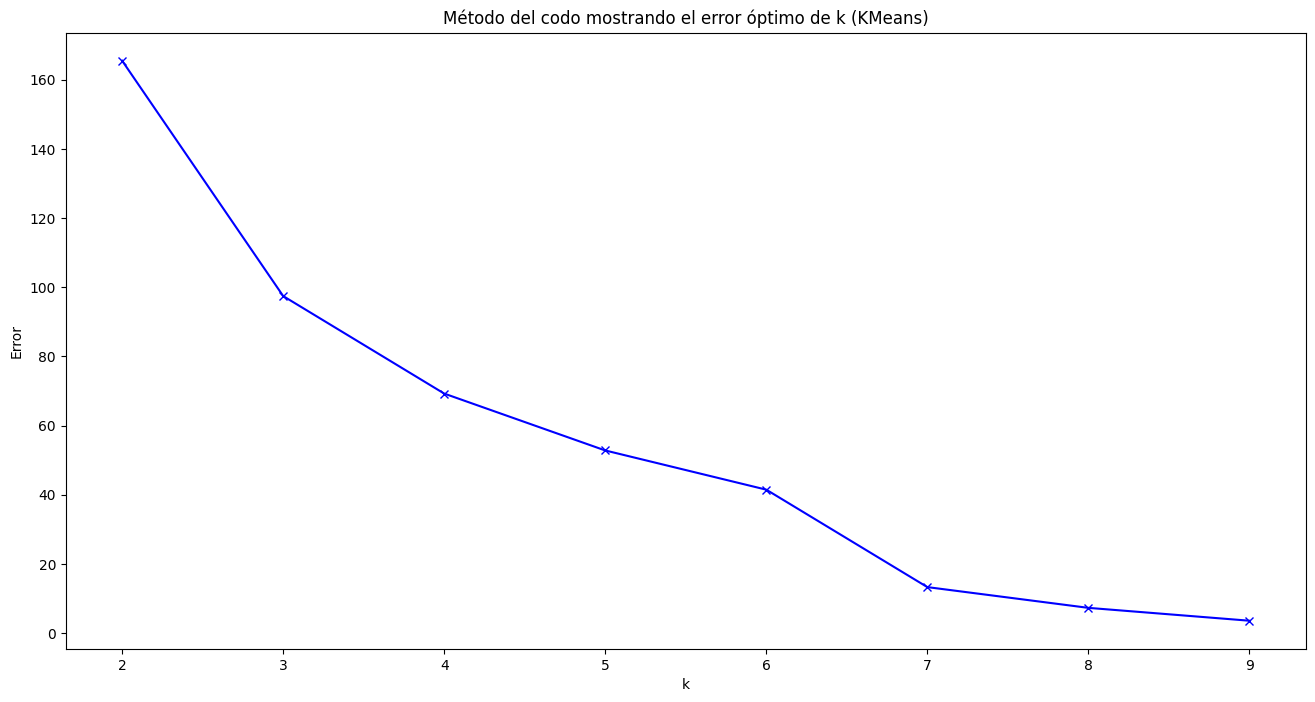

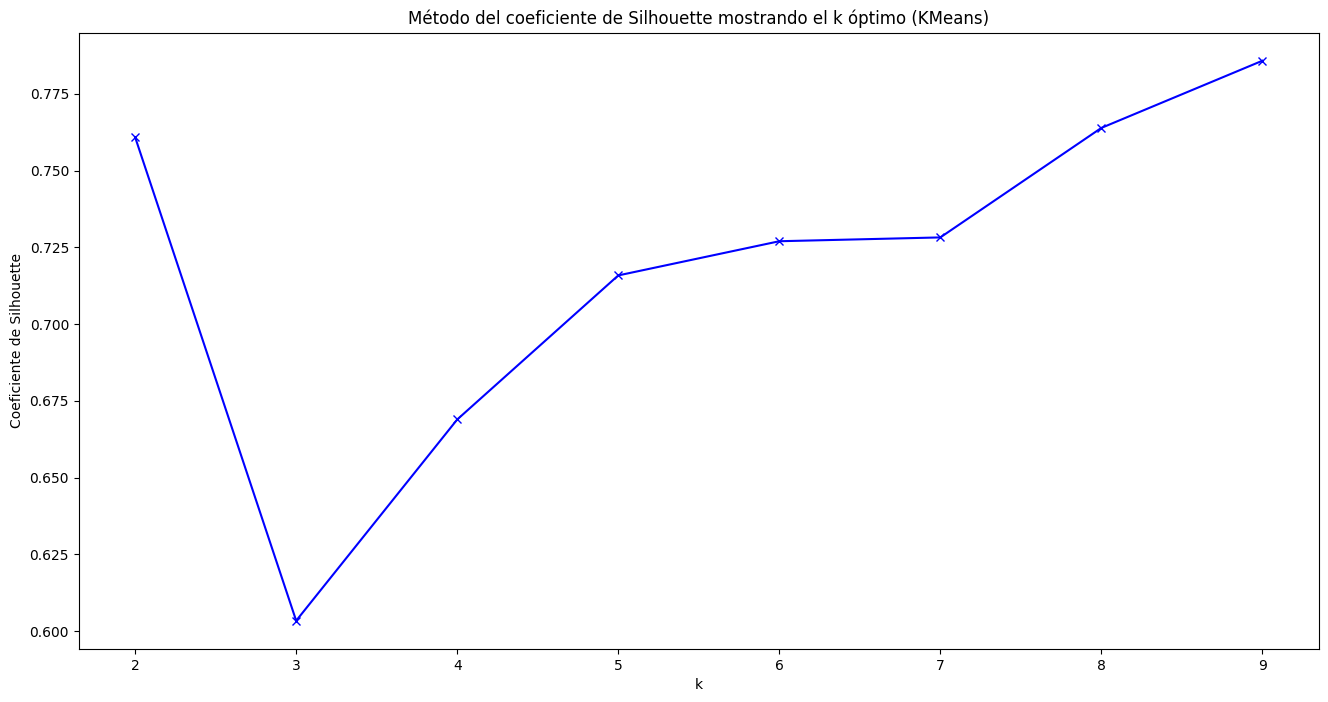

In [5]:
errores_kmeans = []
silhouettes_kmeans = []

# Rango de valores de K que quieres probar
K = range(2, 10)

for k in K:
    # Creando un modelo KMeans con k clústeres
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    # Calculando el error cuadrático medio del modelo KMeans
    error = kmeans.inertia_
    errores_kmeans.append(error)
    
    # Etiquetando cada observación según el clúster indicado por KMeans
    df['Etiqueta_KMeans'] = kmeans.labels_
    # Calculando el coeficiente de Silhouette del modelo KMeans
    silhouette = silhouette_score(X, kmeans.labels_)
    silhouettes_kmeans.append(silhouette)

# Graficando el método del código
plt.figure(figsize=(16,8))
plt.plot(K, errores_kmeans, 'bx-')
plt.xlabel('k')
plt.ylabel('Error')
plt.title('Método del codo mostrando el error óptimo de k (KMeans)')
plt.show()

# Graficando el coeficiente de Silhouette contra K
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes_kmeans, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Método del coeficiente de Silhouette mostrando el k óptimo (KMeans)')
plt.show()

En la gráfica de codo, se nota que los valores que arrojan mejores resultados se sitúan aproximadamente en k = 2 y k = 4. Por otro lado, la distribución en la gráfica del coeficiente de Silhouette no es uniforme entre las observaciones del modelo. En última instancia, se sugiere que el número óptimo de clústeres para este modelo oscilaría entre 2 y 3, ya que con estos valores se podría lograr un rendimiento superior y, en consecuencia, una detección más efectiva del malware durante el análisis por parte de un antivirus.

Reductor de dimensionalidad de los datos analizados

In [6]:
# Reduciendo la dimensionalidad a 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

Gráfico de dispersión de KMeans

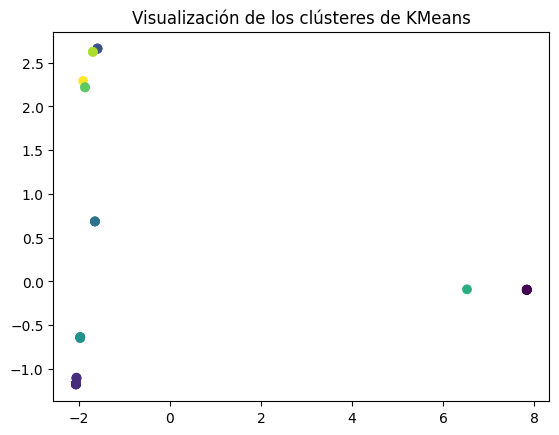

In [7]:
# Creando un gráfico de dispersión de las etiquetas de clúster de KMeans
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=df['Etiqueta_KMeans'])
plt.title('Visualización de los clústeres de KMeans')
plt.show()

Esta gráfica resalta dos características esenciales:

1. El primer clúster engloba las características distintivas de una familia específica de malware, mientras que el clúster 3 podría agrupar observaciones de malware que comparten similitudes en términos de encabezados, contenido, entre otros aspectos.

2. El clúster 2 posiblemente alberga una familia de malware que no comparte ninguna característica identificable con las familias de malware observadas y analizadas en los clústeres 1 y 3.

## Método de AgglomerativeClustering

El siguiente modelo se preparó con lo siguiente:

1. **Inicialización de listas para almacenar inercias y coeficientes de Silhouette**: Primero, se crean dos listas vacías, `inercias_agglo` y `silhouettes_agglo`, que se utilizarán para almacenar las inercias y los coeficientes de Silhouette correspondientes a diferentes valores de K.

2. **Bucle de iteración sobre cada valor de K**: Luego, se itera sobre cada valor de K en el rango definido.

3. **Creación y ajuste del modelo AgglomerativeClustering**: Para cada valor de K, se va creando un modelo `AgglomerativeClustering` con el número correspondiente de clústeres y se ajusta a los datos de entrada `X`.

4. **Cálculo de la "inercia"**: Luego, se calcula la "inercia" del modelo `AgglomerativeClustering` ajustado. En este caso, la "inercia" se calcula como la suma de las distancias euclidianas entre todos los pares de puntos dentro de cada clúster, dividida por el doble del tamaño del clúster.

5. **Almacenamiento de la inercia**: La inercia calculada se va agregando a la lista `inercias_agglo`.

6. **Cálculo del coeficiente de Silhouette**: Después, se calcula el coeficiente de Silhouette del modelo `AgglomerativeClustering` ajustado utilizando la función `silhouette_score` de scikit-learn.

7. **Almacenamiento del coeficiente de Silhouette**: El coeficiente de Silhouette calculado se va agregando a la lista `silhouettes_agglo`.

8. **Etiquetado de las observaciones**: Luego, se etiquetan las observaciones en el DataFrame `df` según los clústeres indicados por el modelo `AgglomerativeClustering`.

9. **Gráficos de los resultados**: Después, se generan dos gráficos para visualizar los resultados del análisis:

    a. **Método del codo**: Se enseña la "inercia" en función del número de clústeres (K). Este gráfico ayuda a visualizar el punto donde la tasa de disminución de la inercia se estabiliza, lo que sugiere un número óptimo de clústeres.
    
    b. **Método del coeficiente de Silhouette**: Se enseña el coeficiente de Silhouette en función del número de clústeres (K). Este gráfico nos ayuda a ver el valor óptimo de K que maximiza la cohesión intraclúster y la separación interclúster.

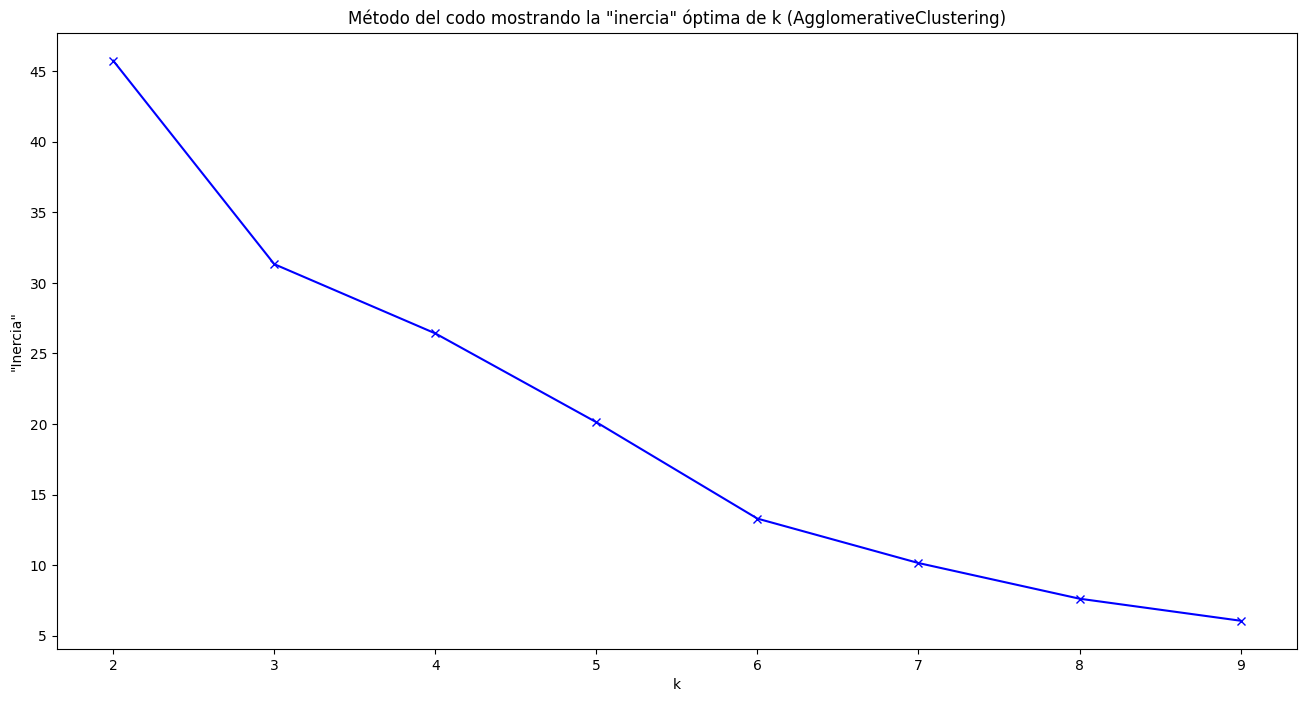

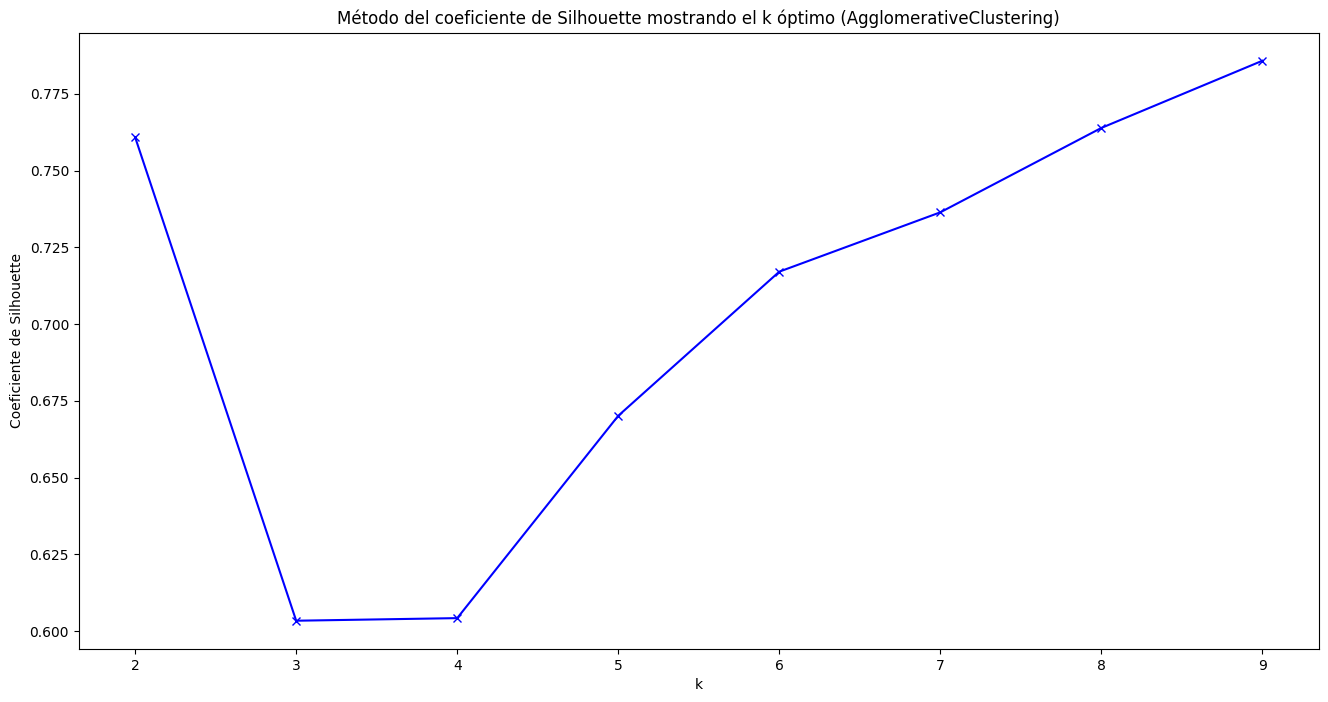

In [8]:
inercias_agglo = []
silhouettes_agglo = []

for k in K:
    # Creando un modelo AgglomerativeClustering con k clústeres
    agglo = AgglomerativeClustering(n_clusters=k)
    labels = agglo.fit_predict(X)
    
    # Calculando la "inercia" del modelo AgglomerativeClustering
    inercia = 0
    for cluster_id in range(k):
        cluster_samples = X[labels == cluster_id]
        if len(cluster_samples) > 1:
            dist_matrix = euclidean_distances(cluster_samples)
            inercia += dist_matrix.sum() / (2 * len(cluster_samples))
    inercias_agglo.append(inercia)
    
    # Calculando el coeficiente de Silhouette del modelo AgglomerativeClustering
    silhouette = silhouette_score(X, labels)
    silhouettes_agglo.append(silhouette)
    
    # Etiquetando cada observación según el clúster indicado por AgglomerativeClustering
    df['Etiqueta_Agglo'] = labels

# Graficando la "inercia" contra K
plt.figure(figsize=(16,8))
plt.plot(K, inercias_agglo, 'bx-')
plt.xlabel('k')
plt.ylabel('"Inercia"')
plt.title('Método del codo mostrando la "inercia" óptima de k (AgglomerativeClustering)')
plt.show()

# Graficando el coeficiente de Silhouette contra K
plt.figure(figsize=(16,8))
plt.plot(K, silhouettes_agglo, 'bx-')
plt.xlabel('k')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Método del coeficiente de Silhouette mostrando el k óptimo (AgglomerativeClustering)')
plt.show()

Se puede observar que el número de clústeres óptimo (basándose en el método del codo) para este modelo está entre 2 y 3, observando así que el valor de k = 3 es el óptimo. Por otro lado, se puede observar que el coeficiente de Silhouette presenta lo siguiente: 

- En k = 2 hay una alta concentración de valores del coeficiente alrededor de 0.5,pero hay observaciones con valores bajos.
- En k = 3 hay una distribución heterogénea, obteniendo así valores bastante similares.
- En k mayores a 3, los valores no parecieran ser adecuados para poder agrupar familias de malware y así detectar su peligro.

Gráfico de dispersión de AgglomerativeClustering

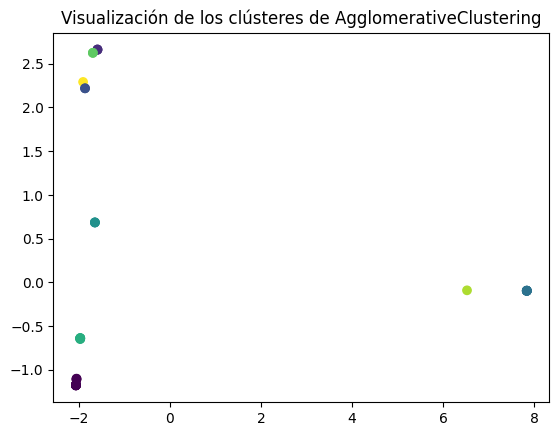

In [9]:
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=df['Etiqueta_Agglo'])
plt.title('Visualización de los clústeres de AgglomerativeClustering')
plt.show()

Esta gráfica de dispersión, al igual que su predecesora, muestra dos observaciones destacadas:

- El primer clúster agrupa dos familias de malware que son notablemente similares o idénticas.
- En contraste, el último clúster contiene una familia de malware que está completamente aislada de las demás, sin similitudes aparentes.

## Índice de Jaccard

In [30]:
df = pd.read_csv('malwr_data.csv')

malware1 = df.iloc[0, 1:]
malware2 = df.iloc[1, 1:]

a = malware1.values
b = malware2.values

# Convertiendo los vectores a valores binarios
a_binary = [1 if value else 0 for value in a]
b_binary = [1 if value else 0 for value in b]

thresholds = [0.5, 0.65, 0.93]

similarity = jaccard_score(a_binary, b_binary, average='binary')

# Clasificar la similitud de acuerdo a cada umbral
for i, threshold in enumerate(thresholds):
    if similarity < threshold:
        print(f'Con un umbral de {threshold}, la similitud es {["baja", "media", "alta"][i]}', "similitud: ", similarity)
    elif i == len(thresholds) - 1:
        print(f'Con un umbral de {threshold}, la similitud es muy alta')

Con un umbral de 0.5, la similitud es baja similitud:  0.484375
Con un umbral de 0.65, la similitud es media similitud:  0.484375
Con un umbral de 0.93, la similitud es alta similitud:  0.484375


## Grafos

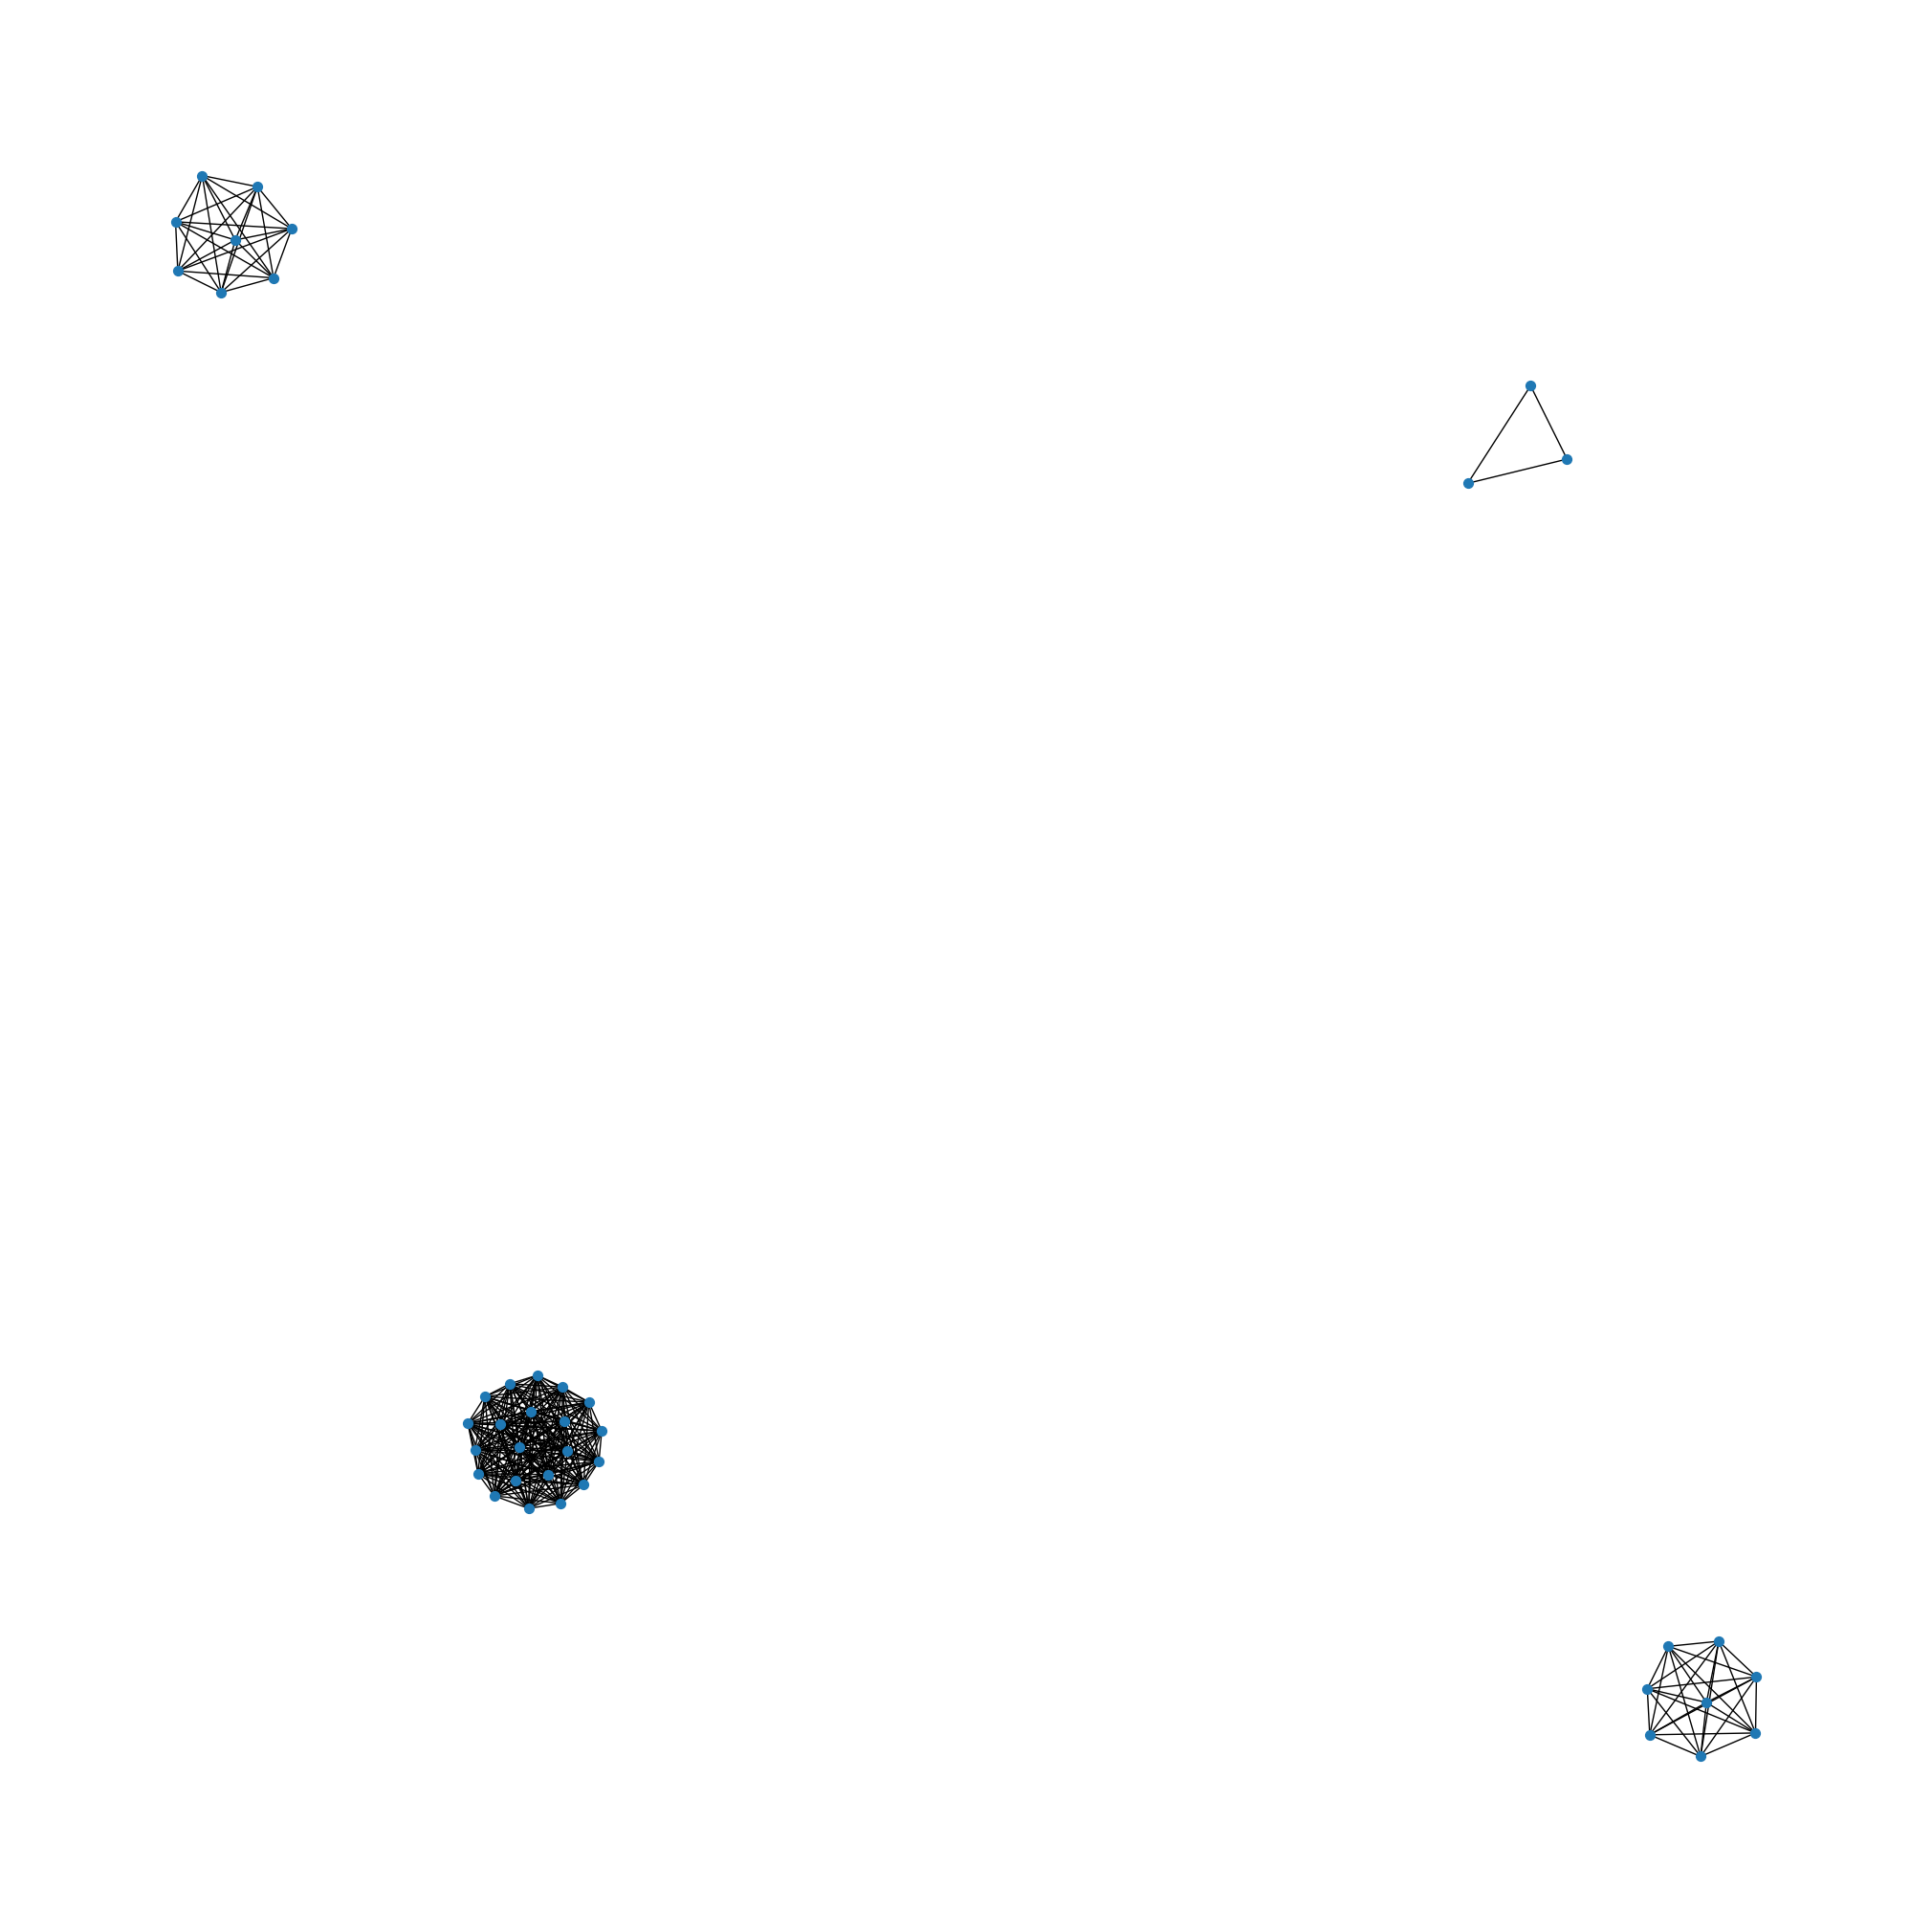

In [61]:
# Creando un grafo vacío
G = nx.Graph()

threshold = 0.4

# Añadiendo nodos al grafo
for i in range(len(X)):
    G.add_node(i)

# Añadiendo bordes al grafo
for i in range(len(X)):
    for j in range(i+1, len(X)):
        # Convertiendo los vectores a binarios
        a_binary = [1 if value else 0 for value in X.iloc[i]]
        b_binary = [1 if value else 0 for value in X.iloc[j]]
        
        # Calculando la similitud entre los nodos i y j
        similarity = jaccard_score(a_binary, b_binary, average='binary')
        # Si la similitud es mayor que un umbral, añadir un borde
        
        if similarity > threshold:
            G.add_edge(i, j)

plt.figure(figsize=(20, 20))

nx.draw(G, node_size=50, width=1)

plt.savefig('graph.png')

plt.show()